$$ \LaTeX \text{ command declarations here.}
\newcommand{\N}{\mathcal{N}}
\newcommand{\R}{\mathbb{R}}
\renewcommand{\vec}[1]{\mathbf{#1}}
\newcommand{\norm}[1]{\|#1\|_2}
\newcommand{\d}{\mathop{}\!\mathrm{d}}
\newcommand{\qed}{\qquad \mathbf{Q.E.D.}}
\newcommand{\vx}{\mathbf{x}}
\newcommand{\vy}{\mathbf{y}}
\newcommand{\vt}{\mathbf{t}}
\newcommand{\vb}{\mathbf{b}}
\newcommand{\vw}{\mathbf{w}}
$$

In [1]:
%matplotlib inline
from Lec06 import *

# EECS 545:  Machine Learning
## Lecture 6:  Bayesian Linear Regression & Gaussian Processes
* Instructor:  **Jacob Abernethy**
* Date:  February 17, 2015

*Lecture Exposition Credit: Ben & Valli*

## Outline for this Lecture
- More on Multivariate Gaussian
    - Partitioned Marginal in Multivariate Gaussian
    - Conditional of Multivariate Gaussian 
    - Bayes' Theorem for Linear Gaussian System
    
- Bayesian Linear Regression
    - Bayesian Linear Regression
    - Sequential Bayesian Learning
    
- Gaussian Processes




## Reading List

- Required:    
    - **[PRML]**, §3.3: Bayesian Linear Regression
    - **[PRML]**, §6.4: Gaussian Processes
- Optional:
    - **[MLAPP]**, §7.6.1-7.6.2: Bayesian Linear Regression
    - **[MLAPP]**, §4.3: Inference in Joinly Gaussian Distributions
    - **[CS229]** Ng, Andrew.  [CS 229:  Machine Learning](http://cs229.stanford.edu/).  Autumn 2015.
        - [Gaussian Processes](http://cs229.stanford.edu/section/cs229-gaussian_processes.pdf)
        - [More on Gaussians](http://cs229.stanford.edu/section/more_on_gaussians.pdf)

> In this lecture, our main goal is to introduce linear regression from a Bayesian perspective which is an extension to last lecture. One important application of this is to let linear regression work in a *online* fashion.

> Specifically, we will first cover some basics of multivariate Gaussians and derive the results of Bayes' Theorem for linear Gaussian system which will be used later. Next we will show how to do linear regression in Bayesian setting. Unlike finding a deterministic estimate of coefficients $\vw$ in previous lectures, we will find a distribution of $\vw$. Then, we will show how to apply Bayesian linear regression to streaming data. Streaming scenarios include realtime measurements, large amount of data that exceeds memory limit, etc.. Finally, we will introduce Gaussian processes and show Bayesian linear regression is actually a Gaussian process.

## More on Multivariate Gaussians

> Taken from **[PRML]** §2.3, **[MLAPP]** §4.3, 4.4, and **[CS229]**

### Multivariate Gaussians: Basics

- For **Multivariate Gaussian** distribution $\vec{x} \sim \N(\vec{\mu}, \Sigma)$, we have
    - **mean** $\vec{\mu} \in \R^D$
    - **covariance matrix** $\Sigma \in \R^{D \times D}$
    - **PDF**
    $$
    \N(\vec{x} | \vec{\mu}, \Sigma)
    = \frac{1}{\sqrt{(2\pi)^D \det( \Sigma )}} \exp\left[ -\frac12 (\vec{x}-\mu)^T \Sigma^{-1} (\vec{x} - \mu) \right]
    $$

### Partitioned Gaussian Distributions

- Partition $\vec{x} \sim \N(\vec{\mu}, \Sigma)$ as
    $$
    \vec{x} = \begin{bmatrix}  \vec{x_a} \\ \vec{x_b} \end{bmatrix}
    \quad
    \ \vec{\mu} = \begin{bmatrix} \vec{\mu_a} \\ \vec{\mu_b} \end{bmatrix}
    \quad
    \Sigma = \begin{bmatrix}
    \Sigma_{aa} & \Sigma_{ab} \\
    \Sigma_{ba} & \Sigma_{bb}
    \end{bmatrix}
    $$
    such that $\vec{x_a}, \vec{\mu_a} \in \R^{D_a}$, $\vec{x_b}, \vec{\mu_b} \in \R^{D_b}$, $\Sigma_{aa} \in \R^{D_a \times D_a}$ and $\Sigma_{bb} \in \R^{D_b \times D_b}$ for some $D_a$ and $D_b$ ($D_a + D_b = D$).
    
- Then we could have marginals
    $$
    \boxed{\begin{matrix}
    \vec{x_a} \sim \N(\vec{\mu_a}, \Sigma_{aa}) \\ 
    \vec{x_b} \sim \N(\vec{\mu_b}, \Sigma_{bb})
    \end{matrix}}
    $$

- Proof is in the **notes**

> **Remark**—Proof for partitioned Gaussian Distribution

>    - For covariance matrix $\Sigma = \begin{bmatrix} \Sigma_{aa} & \Sigma_{ab} \\ \Sigma_{ba} & \Sigma_{bb} \end{bmatrix}$, define $\Lambda = \Sigma^{-1} = \begin{bmatrix} \Lambda_{aa} & \Lambda_{ab} \\ \Lambda_{ba} & \Lambda_{bb} \end{bmatrix}$

>    - **Fact 1** Based on [blockwise inversion of matrix](https://en.wikipedia.org/wiki/Invertible_matrix#Blockwise_inversion), we have 
    $$
    \begin{align}
    \Lambda_{bb} &= (\Sigma_{bb}-\Sigma_{ba} \Sigma_{aa}^{-1} \Sigma_{ab})^{-1} \\
    \Lambda_{ba} &= -\Lambda_{bb}\Sigma_{ba}\Sigma_{aa}^{-1} \\
    \Sigma_{aa} &= (\Lambda_{aa}-\Lambda_{ab} \Lambda_{bb}^{-1} \Lambda_{ba})^{-1}
    \end{align}
    $$

>    - **Fact 2** Based on [determinant of block matrix](https://en.wikipedia.org/wiki/Determinant#Block_matrices), we have
    $$
    \begin{align}
    \det(\Sigma)
    &= \det \left ( \begin{bmatrix} \Sigma_{aa} & \Sigma_{ab} \\ \Sigma_{ba} & \Sigma_{bb} \end{bmatrix} \right ) \\
    &= \det (\Sigma_{aa}) \det (\Sigma_{bb}-\Sigma_{ba}\Sigma_{aa}^{-1}\Sigma_{ab}) \\
    &= \det (\Sigma_{aa}) \det (\Lambda_{bb}^{-1}) 
    \end{align}
    $$    

>    - The **joint PDF** is
    \begin{equation}
    \begin{split}
    P(\vec{x_a}, \vec{x_b}) \quad
    &= \frac{1}{(2 \pi)^{(D_a+D_b)/2}} \frac{1}{(\det{\Sigma})^\frac12} \exp \left \{ -\frac12 \begin{bmatrix}
    (\vec{x_a}-\vec{\mu_a})^T&(\vec{x_b}-\vec{\mu_b})^T 
    \end{bmatrix}
    \begin{bmatrix} \Lambda_{aa} & \Lambda_{ab} \\ \Lambda_{ba} & \Lambda_{bb} \end{bmatrix}
    \begin{bmatrix}
    \vec{x_a}-\vec{\mu_a} \\ 
    \vec{x_b}-\vec{\mu_b}
    \end{bmatrix} \right \} \\
    & = \frac{1}{(2\pi)^{D_a/2}} \frac{1}{\det(\Sigma_{aa})^\frac12} \exp \left\{-\frac12 (\vec{x_a}-\vec{\mu_a})^T \Sigma_{aa}^{-1} (\vec{x_a}-\vec{\mu_a}) \right\} \cdot \\
    & \quad \frac{1}{(2 \pi)^{D_b/2}} \frac{1}{\det(\Lambda_{bb}^{-1})^\frac12} \exp \biggl \{-\frac12 \biggl[ (\vec{x_a}-\vec{\mu_a})^T(\Lambda_{aa}-\Sigma_{aa}^{-1})(\vec{x_a}-\vec{\mu_a}) +\\
    & \quad (\vec{x_b}-\vec{\mu_b})^T\Lambda_{bb}(\vec{x_b}-\vec{\mu_b})+ 2(\vec{x_a}-\vec{\mu_a})^T \Lambda_{ab}(\vec{x_b}-\vec{\mu_b})) \biggl] \biggl\} \qquad \text{(According to } \textbf{Fact 2)}  \\
    & = \N(\vec{x_a}|\vec{\mu_a}, \Sigma_{aa}) \cdot \\
    & \quad \frac{1}{(2 \pi)^{D_b/2}} \frac{1}{\det(\Lambda_{bb}^{-1})^\frac12} \exp \biggl \{-\frac12 \biggl[ (\vec{x_a}-\vec{\mu_a})^T\Lambda_{ab}\Lambda_{bb}^{-1}\Lambda_{ba}(\vec{x_a}-\vec{\mu_a}) + \\
    & \quad (\vec{x_b}-\vec{\mu_b})^T\Lambda_{bb}(\vec{x_b}-\vec{\mu_b})+ 2(\vec{x_a}-\vec{\mu_a})^T \Lambda_{ab}(\vec{x_b}-\vec{\mu_b})) \biggl] \biggl\} \qquad \text{(According to } \textbf{Fact 1)} \\
    & = \N(\vec{x_a}|\vec{\mu_a}, \Sigma_{aa})  \cdot\\
    & \quad \frac{1}{(2 \pi)^{D_b/2}} \frac{1}{\det(\Lambda_{bb}^{-1})^\frac12} \exp \biggl \{-\frac12 \biggl[ (\vec{x_a}-\vec{\mu_a})^T\Lambda_{ab}\Lambda_{bb}^{-1}\Lambda_{bb}\Lambda_{bb}^{-1}\Lambda_{ba}(\vec{x_a}-\vec{\mu_a}) +\\
    & \quad (\vec{x_b}-\vec{\mu_b})^T\Lambda_{bb}(\vec{x_b}-\vec{\mu_b})+ 2(\vec{x_a}-\vec{\mu_a})^T \Lambda_{ab}\Lambda_{bb}^{-1}\Lambda_{bb}(\vec{x_b}-\vec{\mu_b})) \biggl] \biggl\} \\
    & = \N(\vec{x_a}|\vec{\mu_a}, \Sigma_{aa}) \cdot \\
    &\quad \frac{1}{(2 \pi)^{D_b/2}} \frac{1}{\det(\Lambda_{bb}^{-1})^\frac12} \exp \biggl \{-\frac12  [\vec{x_b}-\vec{\mu_b}+\Lambda_{bb}^{-1}\Lambda_{ba}(\vec{x_a}-\vec{\mu_a})]^T\Lambda_{bb}[\vec{x_b}-\vec{\mu_b}+\Lambda_{bb}^{-1}\Lambda_{ba}(\vec{x_a}-\vec{\mu_a})] \biggl\} \\
    & = \boxed{ \N(\vec{x_a}|\vec{\mu_a}, \Sigma_{aa}) \N(\vec{x_b}|\vec{\mu_b}-\Lambda_{bb}^{-1}\Lambda_{ba}(\vec{x_a}-\vec{\mu_a}), \Lambda_{bb}^{-1}) }\\
    \end{split}
    \end{equation}

>    - So the **marginal PDF** is 
    $$
    \begin{equation}
    \begin{split}
    P(\vec{x_a}) 
    & = \int P(\vec{x_a}, \vec{x_b}) \d \vec{x_b} \\
    & = \N(\vec{x_a}|\vec{\mu_a}, \Sigma_{aa}) \int  \N(\vec{x_b}|\vec{\mu_b}-\Lambda_{bb}^{-1}\Lambda_{ba}(\vec{x_a}-\vec{\mu_a}), \Lambda_{bb}^{-1}) \d \vec{x_b} \\
    & = \N(\vec{x_a}|\vec{\mu_a}, \Sigma_{aa}) \cdot 1 \\
    & = \boxed{ \N(\vec{x_a}|\vec{\mu_a}, \Sigma_{aa}) }
    \end{split}
    \end{equation}
    $$
    
>    - Similarly, we could prove $\boxed{ P(\vec{x_a}) = \N(\vec{x_b}|\vec{\mu_b}, \Sigma_{bb}) }\qed$

### Partitioned Marginals:  Bivariate Example

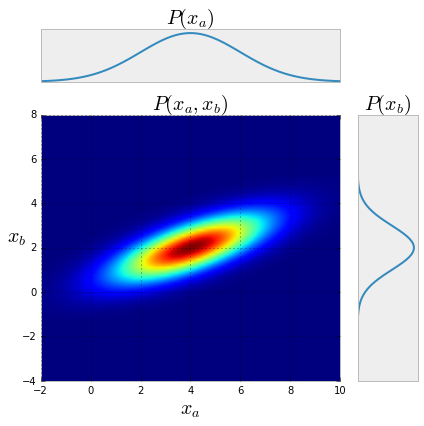

In [2]:
plot_mvn(2, 1, 4, 2, 1); # sigma_x_a, sigma_x_b, mu_x, mu_y, corr

### Partitioned Conditionals

- Given the setting of partition defined above, we have the **conditionals** 
    $$
    \begin{matrix}
    \boxed{
    \begin{align}
    P(\vec{x_b} | \vec{x_a})
    &= \N(\vec{x_b} | \mu_{b|a}, \Sigma_{b|a}) \\
    \Sigma_{b|a}
    &= \Sigma_{bb} - \Sigma_{ba}\Sigma_{aa}^{-1} \Sigma_{ab} \\
    \mu_{b|a}
    &= \mu_b + \Sigma_{ba} \Sigma_{aa}^{-1} (\vec{x_a} - \mu_a)
    \end{align}
    }
    &
    \boxed{
    \begin{align}
    P(\vec{x_a} | \vec{x_b})
    &= \N(\vec{x_a} | \mu_{a|b}, \Sigma_{a|b}) \\
    \Sigma_{a|b}
    &= \Sigma_{aa} - \Sigma_{ab}\Sigma_{bb}^{-1} \Sigma_{ba} \\
    \mu_{a|b}
    &= \mu_a + \Sigma_{ab} \Sigma_{bb}^{-1} (\vec{x_b} - \mu_b)
    \end{align}
    }
    \end{matrix}
    $$

- Proof is in the **notes**

> **Remark**
> - The **conditional** distribution of $\vec{x_a}|\vec{x_b}$ means the distribution of $\vec{x_a}$ given the value of $\vec{x_b}$.

> - For the following notes, we will use $\vec{x_a}|\vec{x_b}$ to denote "**random variable $\vec{x_a}$ given the value of $\vec{x_b}$**"

> - For $\vec{x_a}|\vec{x_b}$, 

>    - Its **Mean** $\mu_{a|b}$ is a linear function w.r.t. $\vec{x_b}$.

>    - Its **Covariance** $\Sigma_{a|b}$ is constant no matter what $\vec{x_b}$ is.

> - **Proof** for partitioned conditionals

>     - From previous **Remark**, we already showed 
$$
    \begin{align}
    P(\vec{x_a}, \vec{x_b}) &= \N(\vec{x_a}|\vec{\mu_a}, \Sigma_{aa}) \N(\vec{x_b}|\vec{\mu_b}-\Lambda_{bb}^{-1}\Lambda_{ba}(\vec{x_a}-\vec{\mu_a}), \Lambda_{bb}^{-1}) \\
    P(\vec{x_a}) &= \N(\vec{x_a}|\vec{\mu_a}, \Sigma_{aa})
    \end{align}
    $$
    So the conditional is
    $$
    P(\vec{x_b}|\vec{x_a}) = \frac{P(\vec{x_a}, \vec{x_b})}{P(\vec{x_a})} = \N(\vec{x_b}|\vec{\mu_b}-\Lambda_{bb}^{-1}\Lambda_{ba}(\vec{x_a}-\vec{\mu_a}), \Lambda_{bb}^{-1})
    $$
    Based on results from **Fact 1** in previous **Remark**, we have
    $$
    P(\vec{x_b}|\vec{x_a}) = \N(\vec{x_b}|\underbrace{\mu_b + \Sigma_{ba}\Sigma_{aa}^{-1}(\vec{x_a}-\mu_a)}_{\mu_{b|a}}, \underbrace{\Sigma_{bb}-\Sigma_{ba}\Sigma_{aa}^{-1}\Sigma_{ab}}_{\Sigma_{b|a}})
    $$
    Similarly we could prove $P(\vec{x_a}|\vec{x_b})$ case. $\qed$

- Illustration of conditionals
<center> <img src="images/partitioned-conditionals.png"  style="width:500px;height:240px;"> </center>
- The conditional is obtained by "slicing" the joint PDF.


### Linear Gaussian Systems:  Model
- **Just then** we have just showed if we partition a multivariate Gaussian into two vectors
    $$
    \begin{bmatrix}  \vec{x_a} \\ \vec{x_b} \end{bmatrix}
    \sim
    \N \left(
    \begin{bmatrix} \vec{\mu_a} \\ \vec{\mu_b} \end{bmatrix},
    \begin{bmatrix}
    \Sigma_{aa} & \Sigma_{ab} \\  \Sigma_{ba} & \Sigma_{bb}
    \end{bmatrix}
    \right)
    $$
    we have the following conditional with mean a **linear** function w.r.t. $\vec{x_b}$
    $$
    P(\vec{x_a} | \vec{x_b}) = \N(\vec{x_a} | \mu_{a|b}, \Sigma_{a|b})
    \quad \mu_{a|b} = \mu_a + \Sigma_{ab} \Sigma_{bb}^{-1} (\vec{x_b} - \mu_b)
    \quad \Sigma_{a|b} = \Sigma_{aa} - \Sigma_{ab}\Sigma_{bb}^{-1} \Sigma_{ba} 
    $$    

- **Now** let's consider a **different** but **similar** setting:
    - We have a **Gaussian** $\vec{x} \in \R^{D_X}$ and **some** $\vec{y} \in \R^{D_Y}$ of which
    $$
    \vec{x} \sim \N(\mu_x, \Sigma_x) \quad (\mu_\vx \text{ and } \Sigma_\vx \text{ are } \textbf{known} )
    $$
    And the conditional relation between $\vec{x}$ and $\vec{y}$ is
    $$
    \vec{y}|\vec{x} \sim \N(A\vec{x}+\vb, \Sigma_{\vy|\vx}) \quad (A, b \text{ and } \Sigma_{\vy|\vx} \text{ are } \textbf{known} )
    $$
    which says $\vy|\vx$ is also a Gaussian with mean $\mu_{\vy|\vx}$ a **linear** function of $\vx$

- **Then**, what is the distribution of $\vy$ and what is the distribution of $\vx|\vy$?
    - Are they also **Gaussian**? 
    - If so, what are the mean and covariance?

### Linear Gaussian Systems:  Bayes' Theorem

- Actually, given
    $$
    \vec{x} \sim \N(\mu_\vx, \Sigma_\vx) \quad \text{and} \quad \vec{y}|\vec{x} \sim \N(A\vec{x}+\vb, \Sigma_{\vy|\vx})
    $$
    we could show 
    $$
    \boxed{\vy \sim \mathcal{N}( A\mu_\vx + \vb, \Sigma_{\vy|\vx} + A\Sigma_\vx A^T)}
    $$
    and
    $$
    \boxed{\vx|\vy \sim \mathcal{N}( \mu_{\vx|\vy}, \Sigma_{\vy|\vx})}
    $$
    of which
    $$
    \begin{align}
    \Sigma_{\vx|\vy} &= (\Sigma_\vx^{-1} + A^T \Sigma_{\vy|\vx}^{-1} A)^{-1} \\
    \mu_{\vx|\vy} &= \Sigma_{\vx|\vy} \left[
    A^T \Sigma_{\vy|\vx}^{-1} (\vy-b) + \Sigma_\vx^{-1} \mu_\vx 
    \right]
    \end{align}
    $$

- Proof is in the **notes**

- This theorem will play a **key role** throughout this lecture.

> **Remark**

> - **Proof for $\vy$ (*Less* rigorous one)**

>    - Let's assume (less rigorous because here we directly assume $\vy$ to have Gaussian distribution)
    $$\vy \sim \N(\mu_\vy, \Sigma_\vy)$$
    So based on conditional of partitioned Gaussion, we have
    $$
    \vy|\vx \sim \N(\mu_\vy + \Sigma_{\vy\vx}\Sigma_{\vx}^{-1}(\vx-\mu_\vx), \Sigma_\vy-\Sigma_{\vy\vx}\Sigma_{\vx}^{-1}\Sigma_{\vx\vy})
    $$
    Since we have known $\vec{y}|\vec{x} \sim \N(A\vec{x}+\vb, \Sigma_{\vy|\vx})$, we could have the following equations
    $$
    \left\{\begin{array}{l}    \Sigma_{\vy\vx}\Sigma_\vx^{-1} = A   \\    \mu_\vy - \Sigma_{\vy\vx} \Sigma_\vx^{-1}\mu_\vx = \vb   \\    \Sigma_\vy-\Sigma_{\vy\vx}\Sigma_\vx^{-1}\Sigma_{\vx\vy} = \Sigma_{\vy|\vx}    \end{array}\right.
    \Rightarrow
    \left\{\begin{array}{l}   \Sigma_{\vy\vx}=A\Sigma_\vx,\ \Sigma_{\vx\vy}=\Sigma_\vx A^T    \\    \mu_\vy=A\mu_\vx+\vb    \\    \Sigma_\vy=\Sigma_{\vy|\vx}+A\Sigma_\vx A^T    \end{array}\right.
    \Rightarrow
    \vy \sim \N(A\mu_\vx + \vb, \Sigma_{\vy|\vx} + A\Sigma_\vx A^T) \qed
    $$


> - **Proof for $\vx|\vy$**

>    - We already have
    $$
    \left\{\begin{array}{l}    \vec{x} \sim \N(\mu_\vx, \Sigma_\vx)   \\    \vy \sim \mathcal{N}( \underbrace{A\mu_\vx + \vb}_{\mu_\vy}, \underbrace{\Sigma_{\vy|\vx} + A\Sigma_\vx A^T)}_{\Sigma_\vy}   \\    \Sigma_{\vy\vx}=A\Sigma_\vx,\ \Sigma_{\vx\vy}=\Sigma_\vx A^T     \end{array}\right.
    $$
    According to conditional of partitioned Gaussian, we know $\vx|\vy$ has Gaussian distribution, so we could assume
    $$\vx|\vy \sim \N(\mu_{\vx|\vy}, \Sigma_{\vx|\vy})$$
    Applying the result of conditional of partitioned Gaussian, we have covariance:
    $$
    \begin{align}
    \Sigma_{\vx|\vy} 
    &= \Sigma_\vx - \Sigma_{\vx\vy} \Sigma_{\vy}^{-1} \Sigma_{\vy\vx} \\
    &= \Sigma_\vx - \Sigma_{\vx}A^T (\Sigma_{\vy|\vx}+A\Sigma_{\vx}A^T)^{-1} A \Sigma_{\vx} \\
    &= \boxed{(\Sigma_\vx^{-1} + A^T \Sigma_{\vy|\vx}^{-1} A)^{-1}}
    \end{align}
    $$
    of which the last equation is based on matrix inversion lemma. 

> - **Proof for $\vx|\vy$**
>    - And we have mean:
    $$
    \begin{align}
    \mu_{\vx|\vy}
    &= \mu_\vx + \Sigma_{\vx\vy}\Sigma_{\vy}^{-1}(\vy-\mu_{\vy}) \\
    &= \mu_\vx + \Sigma_{\vx\vy} \Sigma_{\vy}^{-1} (\vy-A\mu_\vx-\vb) \\
    &= \Sigma_{\vx\vy} \Sigma_{\vy}^{-1} (\vy-\vb) + (I-\Sigma_{\vx\vy} \Sigma_{\vy}^{-1}A)\mu_\vx
    \end{align}
    $$
    of which
    $$
    \begin{align}
    \Sigma_{\vx\vy} \Sigma_{\vy}^{-1}
    &= \Sigma_\vx A^T (\Sigma_{\vy|\vx} + A \Sigma_\vx A^T)^{-1} \\
    &= \Sigma_{\vx|\vy} [ \Sigma_{\vx|\vy}^{-1} \Sigma_\vx A^T (\Sigma_{\vy|\vx} + A \Sigma_\vx A^T)^{-1} ] \\
    &= \Sigma_{\vx|\vy} [(\Sigma_\vx+A^T \Sigma_{\vy|\vx}^{-1} A) \Sigma_\vx A^T (\Sigma_{\vy|\vx} + A \Sigma_\vx A^T)^{-1} ] \\
    &= \Sigma_{\vx|\vy} [ (A^T + A^T \Sigma_{\vy|\vx}^{-1} A \Sigma_\vx A^T) (\Sigma_{\vy|\vx} + A \Sigma_\vx A^T)^{-1} ] \\
    &= \Sigma_{\vx|\vy} A^T [ (I + \Sigma_{\vy|\vx}^{-1} A \Sigma_\vx A^T) (\Sigma_{\vy|\vx} + A \Sigma_\vx A^T)^{-1} ] \\
    &= \Sigma_{\vx|\vy} A^T \Sigma_{\vy|\vx}^{-1} [ (\Sigma_{\vy|\vx} +  A \Sigma_\vx A^T) (\Sigma_{\vy|\vx} + A \Sigma_\vx A^T)^{-1} ] \\
    &= \Sigma_{\vx|\vy} A^T \Sigma_{\vy|\vx}^{-1} \\
    \end{align}
    $$

> - **Proof for $\vx|\vy$**
    $$
    \begin{align}
    I-\Sigma_{\vx\vy} \Sigma_{\vy}^{-1}A 
    &= I-\Sigma_{\vx|\vy} A^T \Sigma_{\vy|\vx}^{-1} A \\
    &= \Sigma_{\vx|\vy} (\Sigma_{\vx|\vy}^{-1} - A^T \Sigma_{\vy|\vx}^{-1} A)\\
    &= \Sigma_{\vx|\vy} (\Sigma_{\vx}^{-1} + A^T \Sigma_{\vy|\vx}^{-1} A - A^T \Sigma_{\vy|\vx}^{-1} A)\\
    &= \Sigma_{\vx|\vy} \Sigma_{\vx}^{-1}
    \end{align}
    $$
    Plug this back to the mean,
    $$
    \begin{align}
    \mu_{\vx|\vy}
    &= \Sigma_{\vx|\vy} A^T \Sigma_{\vy|\vx}^{-1} (\vy - \vb) + \Sigma_{\vx|\vy} \Sigma_{\vx}^{-1} \mu_\vx \\
    &= \boxed{\Sigma_{\vx|\vy} [ A^T \Sigma_{\vy|\vx}^{-1} (\vy - \vb) + \Sigma_{\vx}^{-1} \mu_\vx]} \qed
    \end{align}
    $$

## Bayesian Linear Regression 

> Taken from **[PRML]** §3.3, **[MLAPP]** §7.6

### Review:  Regression
- In last lecture, we have the model for single data point $(\vec{x}, t)$
    $$
    \begin{gather}
    t = \vec{w}^T \phi(\vec{x}) + \epsilon \\ 
    \epsilon \sim \mathcal{N}(0, \beta^{-1}) \\
    t\, | \,\vx,\vw   \sim \mathcal{N}(\vec{w}^T \phi(\vec{x}), \beta^{-1})
    \end{gather}
    $$

- So for inputs $\mathcal{X}=(\vec{x}_1, \dots, \vec{x}_n)$ and target values $\vec{t}=(t_1,\dots,t_n)$, we have
    $$
    \begin{gather}
    \vt\, | \,\mathcal{X}, \vw \sim \N(\Phi \vw, \beta^{-1}I)
    \end{gather}
    $$
    
- Recall in last lecture, if we have **prior** $\vec{w} \sim \mathcal{N}(\vec{0}, \alpha^{-1}I)$, the **MAP Estimate** of $\vw$ corresponds to solution to **ridge regression** (least squares with $\ell^2$ regularization) $$\vec{w}_{MAP} = (\Phi^T \Phi + \frac{\alpha}{\beta} I)^{-1} \Phi^T \vec{t}$$

- Next, we will see what $\vw$'s **posterior** $P(\vw \, | \, \mathcal{X}, \vt)$ is with more general prior.

- Note that $\vec{w}_{MAP}$ is just a single point estimate of **posterior** $P(\vw \, | \, \mathcal{X}, \vt)$. More about this will come later.

> **Remark**
> - Recall **design matrix** $\Phi$ is
    $$
    \Phi = \begin{bmatrix}
    \phi(\vec{x}_1)^T\\ 
    \phi(\vec{x}_2)^T\\ 
    \vdots\\
    \phi(\vec{x}_N)^T
    \end{bmatrix}
    = \begin{bmatrix}
    \phi_0(\vec{x}_1) & \phi_1(\vec{x}_1) & \cdots & \phi_{M-1}(\vec{x}_1) \\
    \phi_0(\vec{x}_2) & \phi_1(\vec{x}_2) & \cdots & \phi_{M-1}(\vec{x}_2) \\
    \vdots & \vdots & \ddots & \vdots \\
    \phi_0(\vec{x}_N) & \phi_1(\vec{x}_N) & \cdots & \phi_{M-1}(\vec{x}_N) \\
    \end{bmatrix}
    $$

### Bayesian Linear Regression
- We have **prior** for coefficients $\vw$
    $$
    P(\vw) = \N(\vw \, | \, \vec{m}_0, S_0)
    $$

- And from last slide, we have **likelihood**
    $$
    P(\vt \, | \, \vw, \mathcal{X}) = \N(\vt \, | \, \Phi \vw, \beta^{-1}I)
    $$

- **Bayesian Linear Regression** computes the full **posterior** over the weights (prior),
    $$
    \begin{align}
    P(\vw \, | \, \vt, \mathcal{X})
    & = \frac{P(\vt \,|\, \vw, \mathcal{X}) P(\vw \,|\, \mathcal{X})}{P(\vt \,|\, \mathcal{X})} \\
    &\propto P(\vt \,|\, \vw, \mathcal{X}) P(\vw \,|\, \mathcal{X}) \\
    &\propto \underbrace{P(\vt \, | \, \vw, \mathcal{X})}_{\text{Likelihood}} \underbrace{P(\vw)}_{\text{Prior}} \qquad \text{(Drop } \mathcal{X} \text{ because of independence)}\\
    &\propto \N(\vt \, | \, \Phi \vw, \beta^{-1}I) \N(\vw \, | \, \vec{m}_0, S_0) \\
    & = \mathcal{N}(\vw \, | \, \vec{m}_N, S_N) \qquad \text{(Can be obtained from some normalization)}
    \end{align}
    $$
    where
    $$
    \boxed{S_N = (S_0^{-1} + \beta \Phi^{T} \Phi)^{-1} \qquad \vec{m}_N = S_N(\beta \Phi^T \vt + S_0^{-1} \vec{m}_0)}
    $$
    
- We will derive this using results we just derived in Bayes' Theorem for Linear Gaussian

> **Remark**

> - Generally, we should follow $$\text{Posterior} = \text{Likelihood} \times \text{Prior}$$ to compute the posterior. But since we have the results from Bayes'Theorem for Linear Gaussian, we will use directly.

> - **Posterior** $P(\vw \, | \, \vt, \mathcal{X})$ tells us our prior belief in $\vw$ with **mean** $\vec{m}_0$ and **covariance** $S_0$ has been updated to **mean** $\vec{m}_N$ and **covariance** $S_N$.

> - We will show this change in some plots later.


### Bayesian Linear Regression: Derivation
- Following the results in Bayes' Theorem for Linear Gaussian, we have
    $$
    \boxed{
    \begin{align}
    & \text{Bayes' Theorem of Linear Gaussian} \\
    \vec{x} & \sim \N(\mu_\vx, \Sigma_\vx) \\
    \vec{y}|\vec{x} & \sim \N(A\vec{x}+\vb, \Sigma_{\vy|\vx}) \\
    & \Downarrow \\
    \vx|\vy &\sim \mathcal{N}( \mu_{\vx|\vy}, \Sigma_{\vy|\vx}) \\
    \Sigma_{\vx|\vy} &= (\Sigma_\vx^{-1} + A^T \Sigma_{\vy|\vx}^{-1} A)^{-1} \\
    \mu_{\vx|\vy} &= \Sigma_{\vx|\vy} \left[A^T \Sigma_{\vy|\vx}^{-1} (\vy-b) + \Sigma_\vx^{-1} \mu_\vx \right] \end{align}
    }
    \Rightarrow
    \boxed{
    \begin{align}
    & \text{Posterior of } \vw\\
    \vw | \mathcal{X} & \sim \N(\vec{m}_0, S_0) \\
    \vt|\vw , \mathcal{X} & \sim \N(\Phi \vw, \beta^{-1}I) \\
    & \Downarrow \\
    \vw|\vt , \mathcal{X} &\sim \N(\vec{m}_N, S_N) \\
    S_N &= (S_0^{-1} + \beta \Phi^{T} \Phi)^{-1} \\
    \vec{m}_N &= S_N(\beta \Phi^T \vt + S_0^{-1} \vec{m}_0 )
    \end{align}
    }
    $$    

- Done!

- Don't get confused by $\mathcal{X}$ in the condition position. We are free to drop it without any impact.

- Think like a Bayesian. Sometimes we usually drop some priors like "Coin is fair" in $P( \text{Head} \,|\, \text{Coin is fair})$

### BLR:  Simplifying the Prior

- Assume $\vec{m}_0 = 0$ and $S_0 = \alpha^{-1}I$ (like what we did in ridge regression), we have
    $$
    P(\vw \, | \, \vt, \mathcal{X}) = \mathcal{N}(\vw \, | \, \vec{m}_N, S_N)
    $$
    where
    $$
    S_N =  (\alpha I + \beta \Phi^T \Phi)^{-1} \\
    \vec{m}_N = \beta S_N \Phi^T \vt = (\Phi^T \Phi + \frac{\alpha}{\beta} I)^{-1} \Phi^T \vt
    $$

- Note that the **posterior mean** $\vec{m}_N$ is the **MAP estimate** of $\vw$. 

- This makes sense because **posterior mean** is exactly the point that maximizes the posterior P(\vw|\vt, \mathcal{X}, \beta).

- **Posterior Covariance** $S_N$ tells us how confident we are in our prediction $\vw_{MAP}$ because it tells us how far $\vw$ are spread out from its mean $\vw_{MAP}$.

### Sequential Bayesian Learning

- Sometimes, our data is *streaming*, and we want to learn $\vw$ in a online fashion.

- **Note:** The posterior $P(\vw\, | \,\vt, \mathcal{X})$ and prior $P(\vw)$ are both Gaussians. 
    - We can use the posterior for one set of observations as a prior for the next set of observations.
    - And following exactly the same procedures as above, we will get a new posterior .
    - Starting from a fixed prior, sequentially update our beliefs as new data arrives.
    
- Here are the details
    - **Initialize** $\vec{m}_0$ and $S_0$ of $\N(\vw \, | \, m_0, S_0)$
    - **Repeat** when the $ith$ obseravation $\{\mathcal{X}_i, \vt_i \}$ arrives
        - $S_i = (S_{i-1}^{-1} + \beta \Phi_{\mathcal{X}_i}^{T} \Phi_{\mathcal{X}_i})^{-1}$
        - $\vec{m}_i = S_i(\beta \Phi_{\mathcal{X}_i}^T \vt_i + S_{i-1}^{-1} \vec{m}_{i-1})$
    - **End**
    
- This is **Bayesian Updating**.

### Sequential Bayesian Learning: Example

- Assume observation $y$ is generated by
    $$y = w_1 x + w_0 + \epsilon$$
    of which
    $$w_1 = 0.5,\ w_0 = -0.3,\ \epsilon \sim \N(0, \beta^{-1})$$
    (We use both $y$ and $t$ to denote observations)
- We want to learn the coefficients $w_1$ and $w_0$ using sequential Bayesian learning.

#### Sequential Bayesian Learning: Example—No Data Comes Yet

<center> <img src="images/sbl1.png"  style="width:571px;height:167px;"> </center>

- **First Plot**—Nothing
- **Second Plot**—Prior $P(\vw) = \N(\vw \, | \, \vec{m}_0, S_0)$
- **Third Plot**—Sample lines of $y = w_1x+w_0$
    - We draw 6 samples $\vw$ based on distribution $\N(\vw \, | \, \vec{m}_0, S_0)$ and plot the lines $y = w_1x+w_0$
    - We could see they are highly scattered and far from the true line $y = 0.5x-0.3$


#### Sequential Bayesian Learning: Example—First Observation Arrives
- First observation $\{y_1, x_1\}$ (has been marked with blue circle in third plot)
    <center> <img src="images/sbl2.png"  style="width:571px;height:167px;;"> </center>

- **First Plot**—Likelihood $P(y = y_1 \, | \, \vw, x_1) = P(y=y_1 \, | \, w_1x_1+w_0, \beta^{-1})$
    - Shows the probability of observing $y_1$ from distribution $\N(\ w_1x_1+w_0, \beta^{-1})$ given different values of $\vw$.
    - $\vw$ from *redder* region are more likely to produce $y_1$ given $x_1$
    - True $\vw=[-0.3, 0.5]$ (marked with white cross) falls in the orange zone.

- **Second Plot**—Posterior $P(\vw \, | \, y_1, x_1) = \N(\vw \, | \, m_1, S_1)$
    - Computed from prior $\N(\vw | m_0, S_0)$ and the first observation
    - Variance is smaller compared with our prior belief
    - The mean is still far from true $\vw=[-0.3, 0.5]$

- **Third Plot**—Sample lines of $y = w_1x + w_0$ where $\vw$ is drawn from $\N(\vw \, | \, m_1, S_1)$
    - Still scattered and far from true line $y = 0.5x-0.3$

#### Sequential Bayesian Learning: Example—Second Observation Arrives
- Second observation $\{y_2, x_2\}$ (has been marked with blue circle in the left corner third plot)
    <center> <img src="images/sbl3.png"  style="width:571px;height:167px;;"> </center>

- **First Plot**—Likelihood $P(y=y_2 \, | \, \vw, x_2) = P(y=y_2 \, | \, w_1x_2+w_0, \beta^{-1})$
    - True $\vw=[-0.3, 0.5]$ (marked with white cross) still falls in the orange zone.

- **Second Plot**—Posterior $P(\vw \, | \, y_1, x_1, y_2, x_2) = \N(\vw \, | \, m_2, S_2)$
    - Computed from posterior $\N(\vw \, | \, m_1, S_1)$ and the second observation
    - Variance is even smaller
    - The mean has moved much closer to $\vw=[-0.3, 0.5]$

- **Third Plot**—Sample lines of $y = w_1x + w_0$ where $\vw$ is drawn from $\N(\vw \, | \, m_2, S_2)$
    - Less scattered and slope is closer to $y = 0.5x-0.3$

#### Sequential Bayesian Learning: Example—More Data Arrives
- More observations $\{y_i, x_i\}_{i=3}^N$ arrive (have been marked with blue circle third plot)
    <center> <img src="images/sbl4.png"  style="width:571px;height:167px;;"> </center>

- **First Plot**—Likelihood $P(y = y_N \, | \, \vw, x_N) = P(y=y_N \, | \, w_1x_N+w_0, \beta^{-1})$
    - Although for different $\{y_i, x_i\}$, the likelihood plots have different slope, true $\vw=[-0.3, 0.5]$ always falls in the highly likely region.
    
- **Second Plot**—Posterior $P(\vw \, | \, \{y_i, x_i\}_{i=1}^N ) = \N(\vw \, | \,  m_N, S_N)$
    - Computed from posterior $\N(\vw \, | \,  m_{N-1}, S_{N-1})$ and the second observation
    - The iridescent ring almost shrinks to a *point* locates at $[-0.3, 0.5]$
    - This indicates the variance is really small and mean is really close to true value.

- **Third Plot**—Sample lines of $y = w_1x + w_0$ where $\vw$ is drawn from $\N(\vw \, | \, m_N, S_N)$
    - The lines almost converge to true $y = 0.5x-0.3$
    
- For details of these plots, please refer to **[PRML]**-P154.

### Predictive Distribution
- Recall our ultimate goal in linear regression is to predict $t$ for new data $\vx$

    - We could take the mean of posterior $\vec{m}_N$ as the estimate of $\vw$ and get a prediction $$t = \vec{m}_N^T \phi(\vx)$$

    - **But**, this could be a waste of the posterior of $\vw$. We want to know more about prediction $t$.

    - Actually, we could obtain distribution of $t$ based on the full posterior of $\vw$

- Let $\mathcal{D} = \{ (t_i, \vx_i) \}_{i=1}^N$ denote the training data. Then the **predictive distributinon** for some **new data** $\vx$ is
    $$
    \begin{align}
    P(t \, | \, \vx, \mathcal{D})
    &= \int_\vw P(t, \vw \, | \, \vx, \mathcal{D}) \, \d \vw \\
    &= \int_\vw  P(t \, | \, \vw, \vx, \mathcal{D})  P(\vw \, | \, \vx, \mathcal{D})  \, \d \vw \\
    &= \int_\vw  P(t \, | \, \vw, \vx)  P(\vw \, | \, \mathcal{D}) \, \d \vw \\
    &= \int_\vw \mathcal{N}(t \, | \, \vw^T\phi(\vx), \beta^{-1})\mathcal{N}(\vw \, | \, \vec{m}_N, S_N)  \, \d \vw
    \end{align}
    $$
    The third quality holds because $t$ is independent of $\mathcal{D}$ and $\vw$ is independent of $\vx$.

### Predictive Distribution: Derivation

- We don't have to take the pains to do integration!
- The results we derived in Bayes' theorem for linear Gaussian will save us!
    $$
    \boxed{
    \begin{align}
    & \text{Previous Results} \\
    \vec{x} & \sim \N(\mu_\vx, \Sigma_\vx) \\
    \vec{y}|\vec{x} & \sim \N(A\vec{x}+\vb, \Sigma_{\vy|\vx}) \\
    & \Downarrow \\
    \vy &\sim \N(A \mu_\vx + b, \Sigma_{\vy|\vx} + A \Sigma_\vx A^T) 
    \end{align}
    }
    \Rightarrow
    \boxed{
    \begin{align}
    & \text{Prediction of } \vw\\
    \vw | \vx, \mathcal{D}  & \sim \N(\vec{m}_N, S_N) \\
    t|\vw, \vx, \mathcal{D} & \sim \N(\phi^T \vw, \beta^{-1}) \\
    & \Downarrow \\
    t \, | \, \vx, \mathcal{D} & \sim \N(\, \phi(\vx)^T \vec{m}_n \,, \,{\beta}^{-1} + \phi(\vx)^T S_N \phi(\vx) \,)
    \end{align}
    }
    $$
- So, we have 
    $$
    \boxed{P(t \, | \, \vx, \mathcal{D}) = \N(t \, | \, \phi(\vx)^T \vec{m}_n \,, \,{\beta}^{-1} + \phi(\vx)^T S_N \phi(\vx) \,)}
    $$
- Done!    

### Predictive Distribution: Derivation

- We don't have to take the pains to do integration!
- The results we derived in Bayes' theorem for linear Gaussian will save us!
    $$
    \boxed{
    \begin{align}
    & \text{Previous Results} \\
    \vec{x} & \sim \N(\mu_\vx, \Sigma_\vx) \\
    \vec{y}|\vec{x} & \sim \N(A\vec{x}+\vb, \Sigma_{\vy|\vx}) \\
    & \Downarrow \\
    \vy &\sim \N(A \mu_\vx + b, \Sigma_{\vy|\vx} + A \Sigma_\vx A^T) 
    \end{align}
    }
    \Rightarrow
    \boxed{
    \begin{align}
    & \text{Prediction of } \vw\\
    \vw | \vx, \mathcal{D}  & \sim \N(\vec{m}_N, S_N) \\
    t|\vw, \vx, \mathcal{D} & \sim \N(\phi^T \vw, \beta^{-1}) \\
    & \Downarrow \\
    t \, | \, \vx, \mathcal{D} & \sim \N(\, \phi(\vx)^T \vec{m}_n \,, \,{\beta}^{-1} + \phi(\vx)^T S_N \phi(\vx) \,)
    \end{align}
    }
    $$
- Done!    

### Predictive Distribution:  Example

- Here the underlying true model we will use is $$t = \sin(2 \pi x) + \epsilon$$ of which $\epsilon$ represents some noise.

- In regression, rather than polynomial basis function we used in previous lectures, we will use 9 Gaussian basis function
    $$
    \phi_j(x) = \exp\left\{ -\frac{(x- \mu_j)}{2s^2} \right\}
    $$

- We will still use streaming fashion.

#### Predictive Distribution:  Example—One Observation
- The observations are marked with blue circles in the plots.
- Green curve is the true model $t = \sin(2 \pi x)$

<center> <img src="images/predictive-n1.png"  style="width:506px;height:190px;"> </center>

- **Left Plot**
    - Red curve gives the mean value of prediction distribution $P(t | x, \mathcal{D}_1)$, which is $\phi(x)^T m_1$
    - Red shaded region spans one standard deviation on either side of the mean
    - Note that smallest deviation/variance occurs near observation point

- **Right Plot**
    - We first draw samples of $\vw$ from $P(\vw | \mathcal{D}_1)$
    - Then plot sample curves $y(x, \vw) = \vw^T \phi(x)$
    - If we draw infinite sample cures, their mean is just the red mean curve in left plot.
- Here $\mathcal{D}_i$ represents the first $i$ observations

#### Predictive Distribution:  Example—Two Observations

<center> <img src="images/predictive-n2.png"  style="width:506px;height:190px;"> </center>

- **Left Plot**
    - Red curve gives the mean value of prediction distribution $P(t | x, \mathcal{D}_2)$, which is $\phi(x)^T m_2$
    - Red Mean Curve starts to resemble the true curve.
    - Red shaded region has shrunk indicating variance becomes smaller

- **Right Plot**
    - We first draw samples of $\vw$ from $P(\vw | \mathcal{D}_2)$
    - Then plot sample curves $y(x, \vw) = \vw^T \phi(x)$
    - The sample curves are still quite scattered


#### Predictive Distribution:  Example—Four Observations

<center> <img src="images/predictive-n4.png"  style="width:506px;height:190px;"> </center>

- **Left Plot**
    - Red curve gives the mean value of prediction distribution $P(t | x, \mathcal{D}_3)$, which is $\phi(x)^T m_3$
    - Red shaded region has further shrunk indicating smaller variance/uncertainty
    - Red shaded region has small height near observation points
    - Our observations have the effect of reducing the variance at their positions.
    
- **Right Plot**
    - We first draw samples of $\vw$ from $P(\vw | \mathcal{D}_2)$
    - Then plot sample curves $y(x, \vw) = \vw^T \phi(x)$
    - The sample curves are still quite scattered


#### Predictive Distribution:  Example—Twenty Five Observations

<center> <img src="images/predictive-n25.png"  style="width:506px;height:190px;"> </center>

- **Left Plot**
    - Red curve gives the mean value of prediction distribution $P(t | x, \mathcal{D}_{25})$, which is $\phi(x)^T m_{25}$
    - Red curve is already very close to the true curve!
    - Red shaded region has shrunk greatly and variance has reduced greatly.
    
- **Right Plot**
    - We first draw samples of $\vw$ from $P(\vw | \mathcal{D}_{25})$
    - Then plot sample curves $y(x, \vw) = \vw^T \phi(x)$
    - The sample curves almost converge to the true curve!

- For details of these plots, please refer to **[PRML]**-P157.

## Gaussian Processes

> Taken from **[CS229]** and **[MLAPP]**

- Now we will show you Bayesian linear regression is actually a Gaussian process.

### Gaussian Processes

- **Motivation**: Here are some data points. What function did they come from?
    - GPs are a nice way of expressing “priors on functions”
    - Applications: Regression and Classification

### Gaussian Processes:  Motivation

- **Multivariate Gaussians** are useful for modeling *finite* collections of real-valued variables.
    - Nice analytical properties
    - Distribution over **random vectors**
    - Easily model *correlations* between variables

- **Gaussian Processes** extend Multivariate Gaussians to *infinite-sized* collections of real-valued variables.
    - Distribution over **random functions**

### Distributions over Functions:  Finite Domain

- How can we parameterize probability distributions over functions?

- Consider the following simple example:
    - Let $\mathcal{X} = \{ x_1, \dots, x_m \}$ be any finite set.
    - Let $\mathcal{H}$ be the set of all functions $h : \mathcal{X} \mapsto \R$.

- For example, one function $h_0 \in \mathcal{H}$ is
    $$
    h_0(x_1) = 5 \quad h_0(x_2) = 2.3 \quad \cdots \quad h_0(x_{m-1}) = -\pi \quad h_0(x_m) = 8
    $$

- Then $h_0$ could be represented as a vector $\vec{h_0} = [5, 2.3, \dots, \pi, 8]$

- Any function $h \in \mathcal{H}$ can be represented as a vector.

### Distributions over Functions:  Finite Domain

- To specify a distribution over $\mathcal{H}$, exploit the one-one mapping to $\R^m$
    - Assume a distribution over vectors, $\vec{h} \sim \mathcal{N}(\vec{\mu}, \sigma^2 I)$.

- This **induces** a distribution over $\mathcal{H}$ given by likelihoods at each *"sample point"*:
    $$
    P(h) = P(\vec{h}) = \prod_{k=1}^m \frac{1}{\sqrt{2\pi} \sigma} \exp\left[ -\frac{1}{2\sigma^2} ( f(x_k) - \mu_k )^2 \right]
    $$

### Distributions over Functions:  Infinite Domain

- A **stochastic process** is a collection of random variables, $f = \{ f(x) \}_{x \in \mathcal{X}}$ with index set $\mathcal{X}$, e.g.
    - Dirichlet Processes, Poisson Processes, etc.

- A **Gaussian Process** is a stochastic process such that any finite subcollection of random variables has a multivariate Gaussian distribution

### Gaussian Processes:  Definition

- We say $f(\cdot) \sim \mathcal{GP}(m, k)$ is drawn from a Gaussian process with
    - mean function $m(\cdot) : \mathcal{X} \mapsto \R$
    - covariance or kernel function $k(\cdot, \cdot) : \mathcal{X} \times \mathcal{X} \mapsto \R$

 provided that for any finite set $\{x_1, \dots, x_m\} \subset \mathcal{X}$, the associated random variables have distribution
$$
\begin{bmatrix}
f(x_1) \\ \vdots \\ f(x_m)
\end{bmatrix}
\sim
\mathcal{N}\left(
\begin{bmatrix}
m(x_1) \\ \vdots \\ m(x_m)
\end{bmatrix},
\begin{bmatrix}
k(x_1, x_1) & \cdots & k(x_1, x_m) \\
\vdots & \ddots & \vdots \\
k(x_m, x_1) & \cdots & k(x_m, x_m)
\end{bmatrix}
\right)
$$

### Gaussian Processes:  Interpretation

- Intuitively, $f \sim \mathcal{GP}(m, k)$ is an 
    - extremely high-dimensional vector
    - drawn from an extremely high-dimensional Gaussian

- Each dimension corresponds to an element $x \in \mathcal{X}$,
    - the corresponding component of the vector represents $f(x)$

### Gaussian Processes:  Mean and Covariance

- The **mean function** $m(\cdot) : \mathcal{X} \mapsto \R$ can be any function.
    - For most applications, we set $m \equiv 0$.

- The **covariance function** $k(\cdot, \cdot) : \mathcal{X} \times \mathcal{X} \mapsto \R$ must be a valid kernel.
    - $f(x)$ and $f(x')$ will have high covariance if $x$ and $x'$ are "nearby"
    - Therefore, kernel controls **smoothness**

### Gaussian Processes:  Example

- When $m \equiv 0$, the choice of kernel defines the prior.
    - (Left) Gaussian Kernel $k(x, x') = \exp(−\theta ||x − x'||_2^2)$
    - (Right) Exponential Kernel $k(x, x') = \exp(−\theta ||x − x'||_1)$

- Samples from a Gaussian Process:

<center><img src="images/gpleft.png"></center>

### Linear Regression Revisited

- **Model:**  Assume $y \approx w^T \phi(x)$ is a combination of $M$ fixed basis functions.
    $$
    \begin{align}
    w &\sim \mathcal{N}(w_0, S_0) \\
    y | x, w, \beta &\sim \mathcal{N}(w^T \phi(x_n), \beta^{-1})
    \end{align}
    $$

- Given training points $x_1, \dots, x_N$, what is the joint distribution $P(\vec{y})$ of $y(x_1), \dots, y(x_N)$?
    $$
    \vec{y} = \Phi w = \begin{bmatrix} y(x_1) & \cdots & y(x_N) \end{bmatrix}^T
    $$

### Linear Regression Revisited

- Note $\vec{y} = \Phi w$ is a linear combination of Gaussians $w$, so is itself Gaussian!

    $$
    \begin{align}
    \mathrm{E}[\vec{y}]
    &= \Phi E[w] = 0 \\
    \mathrm{Cov}[\vec{y}] 
    &= \mathrm{E}[yy^T]
    = \Phi \mathrm{E}[ww^T] \Phi^T
    = \frac{1}{\alpha} \Phi \Phi^T
    = K
    \end{align}
    $$

- where $K = [ k(x_i, x_j) ]_{i,j} \in \R^{N \times N}$ is the **Gram Matrix** over the training data with kernel
    $$
    k(x_i, x_j) = \frac{1}{\alpha} \phi(x_i)^T \phi(x_j)
    $$

### Bayesian Linear Regression

- So, Bayesian Kernel Linear Regression is a Gaussian Process!
    - Kernel $k(\cdot, \cdot)$ is dot product in feature space.
    $$
    \begin{align}
    y &= f(x) + \epsilon \\
    f &\sim \mathcal{GP}(0, k(\cdot, \cdot)) \\
    \epsilon &\sim \mathcal{N}(0, \sigma^2)
    \end{align}
    $$

> Features in BLR $\iff$ Kernel functions for GPs

- In general, $k(\cdot, \cdot)$ can be any valid kernel,
- See the book for more details.